In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm

C:\Users\liamc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
members =members.loc[(members['bd']>2) & (members['bd']<99)]
train = pd.read_csv(r'E:\KKbox\train.csv')
df = pd.merge(members,train,how='inner',on=['msno'])
df = df.iloc[0:50000]
msnos = df['msno']
relevant_user_logs = pd.read_csv(r'E:\KKbox\relevant_user_logs.csv')
#relevant_transactions = pd.read_csv(r'C:\Users\liamc\OneDrive\Desktop\Data Science\KKbox\relevant_transactions.csv')                                 

In [18]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'],format='%Y%m%d')

In [19]:
mean_user_logs = pd.DataFrame(index=[],columns=[])

In [20]:
mean_user_logs['num_25'] = relevant_user_logs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = relevant_user_logs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = relevant_user_logs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = relevant_user_logs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = relevant_user_logs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = relevant_user_logs.groupby('msno')['date'].count()

In [21]:
mean_user_logs = mean_user_logs.reset_index()

In [22]:
df = pd.merge(df,mean_user_logs,how='inner',on='msno')

In [23]:
end_day = datetime.date(2017,3,1)
df['days_since_registered'] = end_day - df['registration_init_time']
df['days_since_registered'] = df['days_since_registered'].dt.days

In [24]:
df = pd.get_dummies(df,columns=['city','registered_via','gender'])

In [32]:
df = df.drop(['registration_init_time'],axis=1)

In [33]:
df.head()

,msno,bd,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,city_20,city_21,city_22,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,gender_female,gender_male
0,tlGR5F/+vDFsnQme+KnvXKsCh3y31I1/dBaGuHDfdII=,39,0,0.000000,0.0,0.666667,0.0,11.666667,5.666667,34409.561667,...,0,0,0,0,0,1,0,0,1,0
1,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,22,0,27.400000,4.6,1.400000,4.6,28.600000,50.800000,8129.652200,...,0,0,0,0,0,1,0,0,1,0
2,eIOUZ5I+NV/3EDfn/U/tMepn4FJt2SdzOrWGH1tNlYI=,24,0,1.500000,1.5,0.500000,1.5,5.500000,6.500000,1570.918250,...,0,0,0,1,0,0,0,0,0,1
3,fkLgfIOX0bWM9/BQQChOCDzoos23szsckxPvxrBbtmY=,20,0,12.333333,2.0,1.000000,2.0,37.333333,31.333333,8934.766667,...,0,0,0,0,0,0,1,0,1,0
4,0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=,23,0,9.000000,2.0,2.200000,2.0,79.200000,66.600000,18840.851600,...,0,0,0,0,0,1,0,0,1,0


In [34]:
df.columns

Index(['msno', 'bd', 'is_churn', 'num_25', 'num_50', 'num_75', 'num_985',
       'num_100', 'num_unq', 'total_secs', 'days_logged',
       'days_since_registered', 'city_1', 'city_3', 'city_4', 'city_5',
       'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12',
       'city_13', 'city_14', 'city_15', 'city_16', 'city_17', 'city_18',
       'city_19', 'city_20', 'city_21', 'city_22', 'registered_via_3',
       'registered_via_4', 'registered_via_7', 'registered_via_9',
       'registered_via_13', 'gender_female', 'gender_male'],
      dtype='object')

In [40]:
y = df['is_churn']
X = df.drop(['is_churn','msno'],axis=1)

In [41]:
features = df.drop(['is_churn','msno'],axis=1).columns

In [42]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\liamc\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [43]:
vif

,VIF Factor,features
0,1.118491,bd
1,1.814999,num_25
2,inf,num_50
3,1.672319,num_75
4,inf,num_985
5,34.367025,num_100
6,4.478244,num_unq
7,38.598823,total_secs
8,1.009836,days_logged
9,1.873231,days_since_registered


In [44]:
y = df['is_churn']
X = df[['bd','num_25','num_75','num_unq','days_logged','days_since_registered']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=21)

In [46]:
logreg = LogisticRegression()

In [47]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
y_pred = logreg.predict(X_test)

In [58]:
rounded_proba = np.round(y_pred_prob)
sum(rounded_proba)

0.0

In [60]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5832    0]
 [ 354    0]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      5832
          1       0.00      0.00      0.00       354

avg / total       0.89      0.94      0.92      6186



C:\Users\liamc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


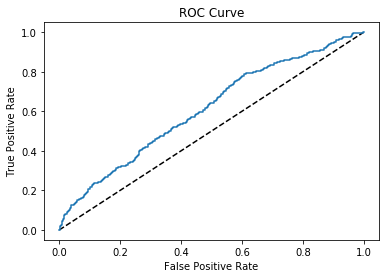

In [61]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [52]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.6095843698898731
AUC scores computed using 5-fold cross-validation: [0.63964877 0.60399073 0.58514525 0.62812071 0.64513592]


In [53]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05, 'penalty': 'l1'}
Best score is 0.9418469298671064


In [54]:
log_loss(y_test,y_pred_prob)

0.21540831047637657